In [29]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, TensorDataset, Dataset
from torch.optim import Adam
from torchvision.io import read_image
import torchvision.transforms as T
from torchvision.transforms.functional import resized_crop
import torchvision.models as models

import numpy as np
import matplotlib.pyplot as plt

import pandas as pd 

import torchsummary

In [30]:
import os 

# print number of cpus 

os.cpu_count()

12

In [31]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

cuda


In [32]:
model = models.efficientnet_b0(pretrained=True).to(device)

# summary 
torchsummary.summary(model, (3, 256, 256))



c:\Users\yinch\Documents\Machine-Learning\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\yinch\Documents\Machine-Learning\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Layer (type:depth-idx)                        Output Shape              Param #
├─Sequential: 1-1                             [-1, 1280, 8, 8]          --
|    └─Conv2dNormActivation: 2-1              [-1, 32, 128, 128]        --
|    |    └─Conv2d: 3-1                       [-1, 32, 128, 128]        864
|    |    └─BatchNorm2d: 3-2                  [-1, 32, 128, 128]        64
|    |    └─SiLU: 3-3                         [-1, 32, 128, 128]        --
|    └─Sequential: 2-2                        [-1, 16, 128, 128]        --
|    |    └─MBConv: 3-4                       [-1, 16, 128, 128]        1,448
|    └─Sequential: 2-3                        [-1, 24, 64, 64]          --
|    |    └─MBConv: 3-5                       [-1, 24, 64, 64]          6,004
|    |    └─MBConv: 3-6                       [-1, 24, 64, 64]          10,710
|    └─Sequential: 2-4                        [-1, 40, 32, 32]          --
|    |    └─MBConv: 3-7                       [-1, 40, 32, 32]          15,350
|    

Layer (type:depth-idx)                        Output Shape              Param #
├─Sequential: 1-1                             [-1, 1280, 8, 8]          --
|    └─Conv2dNormActivation: 2-1              [-1, 32, 128, 128]        --
|    |    └─Conv2d: 3-1                       [-1, 32, 128, 128]        864
|    |    └─BatchNorm2d: 3-2                  [-1, 32, 128, 128]        64
|    |    └─SiLU: 3-3                         [-1, 32, 128, 128]        --
|    └─Sequential: 2-2                        [-1, 16, 128, 128]        --
|    |    └─MBConv: 3-4                       [-1, 16, 128, 128]        1,448
|    └─Sequential: 2-3                        [-1, 24, 64, 64]          --
|    |    └─MBConv: 3-5                       [-1, 24, 64, 64]          6,004
|    |    └─MBConv: 3-6                       [-1, 24, 64, 64]          10,710
|    └─Sequential: 2-4                        [-1, 40, 32, 32]          --
|    |    └─MBConv: 3-7                       [-1, 40, 32, 32]          15,350
|    

In [33]:
print(model.classifier[-1])

Linear(in_features=1280, out_features=1000, bias=True)


In [34]:
df = pd.read_csv("./data/labels.csv")
breeds = df.breed.unique()
map = {} 
for i, breed in enumerate(breeds):
    map[breed] = i

In [35]:
def get_dim(img, target_dim):
    channels, height, width = img.size()
    if height <= width: 
        new_height = target_dim
        new_width = int(width * target_dim / height)
    else: 
        new_width = target_dim
        new_height = int(height * target_dim / width)
    return new_height, new_width

In [36]:
img_width = 256
img_height = 256

In [37]:
import random
class CustomDataset(Dataset):
    def __init__(self, csv_file, base_dir, map):
        self.annotations = pd.read_csv(csv_file)
        self.base_dir = base_dir
        self.annotations
        self.map = map

    def custom_transforms(self, img, target_dim):
        new_height, new_width = get_dim(img, target_dim)
        seq = T.Compose([
            T.Resize((new_height, new_width)),
            T.RandomHorizontalFlip(0.5),
            T.RandomGrayscale(0.2),
            T.RandomCrop((target_dim, target_dim)),
            T.RandomAdjustSharpness(0.2)
        ])
        return seq

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        img_path = self.base_dir + '/' + self.annotations.iloc[index, 0] + '.jpg'
        image = read_image(img_path)
        y_label = torch.tensor(self.map[self.annotations.iloc[index, 1]])
        # apply custom transforms
        image = self.custom_transforms(image, img_width)(image).float()
        return (image, y_label)
    

In [38]:
dataset = CustomDataset(
    csv_file="./data/labels.csv",
    base_dir="./data/train",
    map=map, 
    )



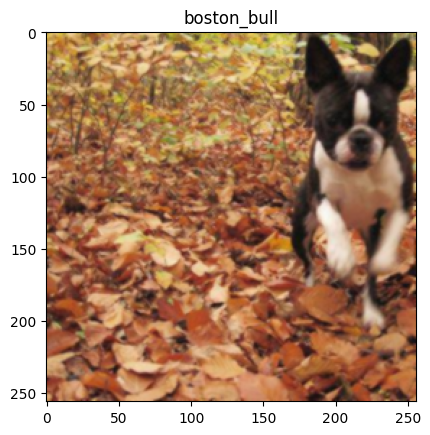

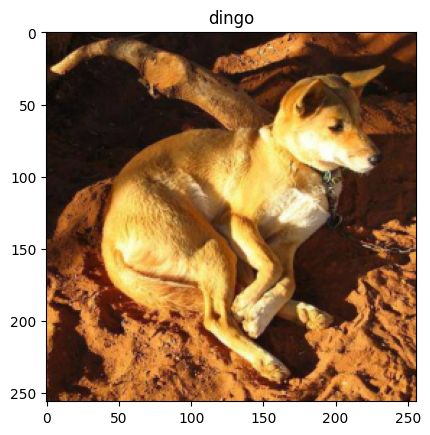

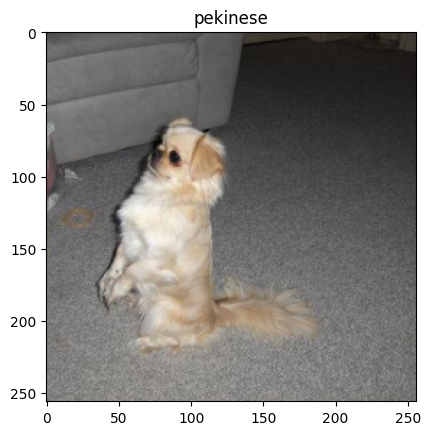

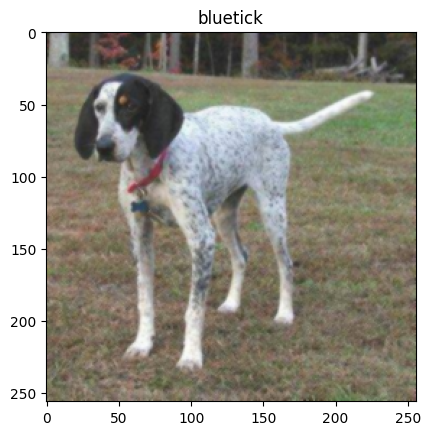

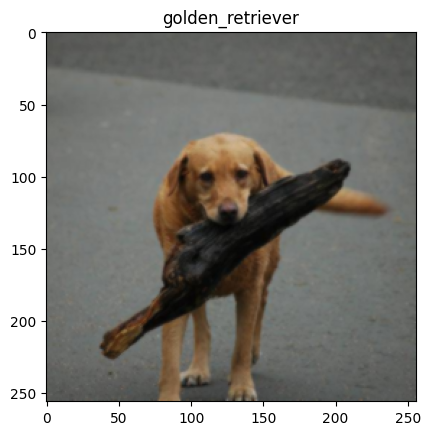

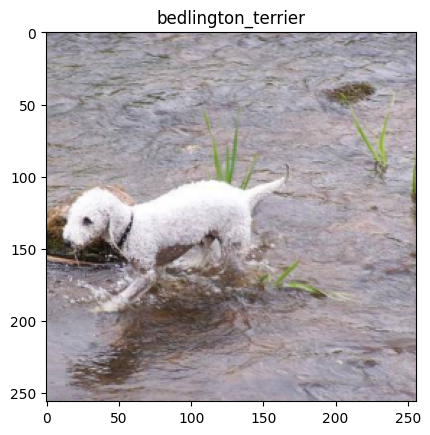

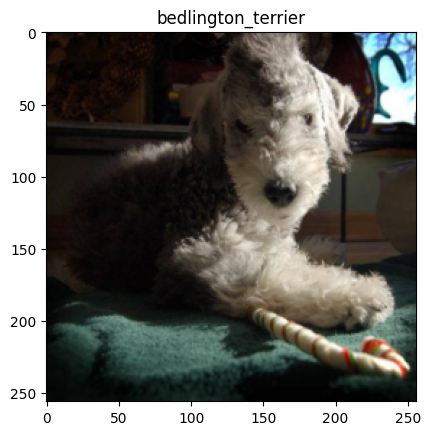

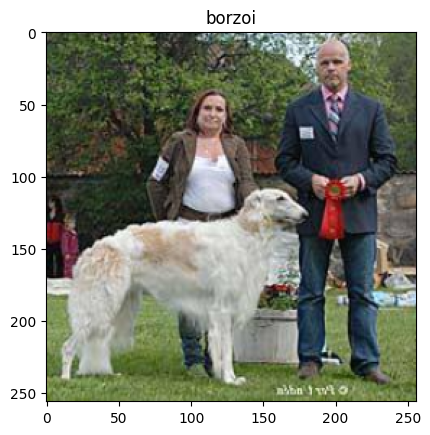

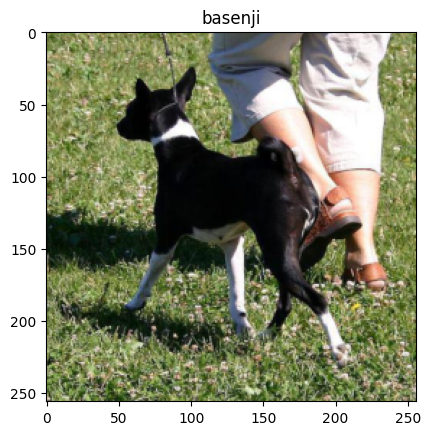

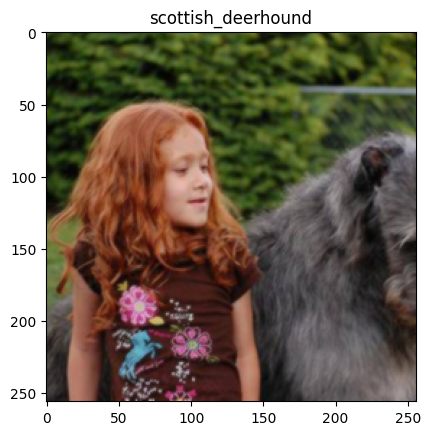

In [39]:
# see some images and labels 

for i in range(10): 
    image, label = dataset[i]
    plt.imshow(image.permute(1, 2, 0).int())
    plt.title(breeds[label])
    plt.show()

In [40]:
train_size = int(0.95 * len(dataset))

test_size = len(dataset) - train_size

train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])


overfit_dataset = torch.utils.data.Subset(train_dataset, range(200))

train_loader = DataLoader(dataset=train_dataset, batch_size=110, shuffle=True, pin_memory=True)

test_loader = DataLoader(dataset=test_dataset, batch_size=110, shuffle=False, pin_memory=True)

overfit_loader = DataLoader(dataset=overfit_dataset, batch_size=110, shuffle=True, pin_memory=True)

In [41]:
class Mod_EfficientNet(nn.Module):
    def __init__(self, num_classes):
        super(Mod_EfficientNet, self).__init__()
        self.model = models.efficientnet_b0(pretrained=True)
        # freeze the model
        for param in self.model.parameters():
            param.requires_grad = False
        
        self.model.classifier[-1] = nn.Linear(1280, num_classes)

    def forward(self, x):
        return self.model(x)
    


In [42]:
model = Mod_EfficientNet(len(breeds)).to(device)


c:\Users\yinch\Documents\Machine-Learning\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\yinch\Documents\Machine-Learning\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [43]:
torchsummary.summary(model, (3, 256, 256))

Layer (type:depth-idx)                        Output Shape              Param #
├─EfficientNet: 1-1                           [-1, 120]                 --
|    └─Sequential: 2-1                        [-1, 1280, 8, 8]          --
|    |    └─Conv2dNormActivation: 3-1         [-1, 32, 128, 128]        (928)
|    |    └─Sequential: 3-2                   [-1, 16, 128, 128]        (1,448)
|    |    └─Sequential: 3-3                   [-1, 24, 64, 64]          (16,714)
|    |    └─Sequential: 3-4                   [-1, 40, 32, 32]          (46,640)
|    |    └─Sequential: 3-5                   [-1, 80, 16, 16]          (242,930)
|    |    └─Sequential: 3-6                   [-1, 112, 16, 16]         (543,148)
|    |    └─Sequential: 3-7                   [-1, 192, 8, 8]           (2,026,348)
|    |    └─Sequential: 3-8                   [-1, 320, 8, 8]           (717,232)
|    |    └─Conv2dNormActivation: 3-9         [-1, 1280, 8, 8]          (412,160)
|    └─AdaptiveAvgPool2d: 2-2         

Layer (type:depth-idx)                        Output Shape              Param #
├─EfficientNet: 1-1                           [-1, 120]                 --
|    └─Sequential: 2-1                        [-1, 1280, 8, 8]          --
|    |    └─Conv2dNormActivation: 3-1         [-1, 32, 128, 128]        (928)
|    |    └─Sequential: 3-2                   [-1, 16, 128, 128]        (1,448)
|    |    └─Sequential: 3-3                   [-1, 24, 64, 64]          (16,714)
|    |    └─Sequential: 3-4                   [-1, 40, 32, 32]          (46,640)
|    |    └─Sequential: 3-5                   [-1, 80, 16, 16]          (242,930)
|    |    └─Sequential: 3-6                   [-1, 112, 16, 16]         (543,148)
|    |    └─Sequential: 3-7                   [-1, 192, 8, 8]           (2,026,348)
|    |    └─Sequential: 3-8                   [-1, 320, 8, 8]           (717,232)
|    |    └─Conv2dNormActivation: 3-9         [-1, 1280, 8, 8]          (412,160)
|    └─AdaptiveAvgPool2d: 2-2         

In [44]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001)


In [45]:
n_eopchs = 12
model.train()
for epoch in range(n_eopchs):
    running_loss = 0
    correct = 0 
    total = 0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        correct += (outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)
        loss = criterion(outputs, labels)
        running_loss += loss.item()
        loss.backward()
        optimizer.step()
    print(f"Epoch: {epoch}, Loss: {running_loss/len(train_loader)}, Accuracy: {correct / total * 100}%")

KeyboardInterrupt: 

In [22]:
# try on test dataset 

model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        correct += (outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)
print(f"Accuracy: {correct / total * 100}%")


Accuracy: 72.0703125%


In [25]:
# new model allow all layers to be trained

class All_Layers_EfficientNet(nn.Module):
    def __init__(self, num_classes):
        super(All_Layers_EfficientNet, self).__init__()
        self.model = models.efficientnet_b0(pretrained=True)
        self.model.classifier[-1] = nn.Linear(1280, num_classes)

    def forward(self, x):
        return self.model(x)
    

In [26]:
new_model = All_Layers_EfficientNet(len(breeds)).to(device)
# load the weights from the previous model
new_model.load_state_dict(model.state_dict())
torchsummary.summary(new_model, (3, 256, 256))


c:\Users\yinch\Documents\Machine-Learning\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\yinch\Documents\Machine-Learning\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Layer (type:depth-idx)                        Output Shape              Param #
├─EfficientNet: 1-1                           [-1, 120]                 --
|    └─Sequential: 2-1                        [-1, 1280, 8, 8]          --
|    |    └─Conv2dNormActivation: 3-1         [-1, 32, 128, 128]        928
|    |    └─Sequential: 3-2                   [-1, 16, 128, 128]        1,448
|    |    └─Sequential: 3-3                   [-1, 24, 64, 64]          16,714
|    |    └─Sequential: 3-4                   [-1, 40, 32, 32]          46,640
|    |    └─Sequential: 3-5                   [-1, 80, 16, 16]          242,930
|    |    └─Sequential: 3-6                   [-1, 112, 16, 16]         543,148
|    |    └─Sequential: 3-7                   [-1, 192, 8, 8]           2,026,348
|    |    └─Sequential: 3-8                   [-1, 320, 8, 8]           717,232
|    |    └─Conv2dNormActivation: 3-9         [-1, 1280, 8, 8]          412,160
|    └─AdaptiveAvgPool2d: 2-2                 [-1, 1280,

Layer (type:depth-idx)                        Output Shape              Param #
├─EfficientNet: 1-1                           [-1, 120]                 --
|    └─Sequential: 2-1                        [-1, 1280, 8, 8]          --
|    |    └─Conv2dNormActivation: 3-1         [-1, 32, 128, 128]        928
|    |    └─Sequential: 3-2                   [-1, 16, 128, 128]        1,448
|    |    └─Sequential: 3-3                   [-1, 24, 64, 64]          16,714
|    |    └─Sequential: 3-4                   [-1, 40, 32, 32]          46,640
|    |    └─Sequential: 3-5                   [-1, 80, 16, 16]          242,930
|    |    └─Sequential: 3-6                   [-1, 112, 16, 16]         543,148
|    |    └─Sequential: 3-7                   [-1, 192, 8, 8]           2,026,348
|    |    └─Sequential: 3-8                   [-1, 320, 8, 8]           717,232
|    |    └─Conv2dNormActivation: 3-9         [-1, 1280, 8, 8]          412,160
|    └─AdaptiveAvgPool2d: 2-2                 [-1, 1280,

In [27]:
n_eopchs = 10 

new_model.train()
for epoch in range(n_eopchs):
    running_loss = 0
    correct = 0 
    total = 0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = new_model(images)
        correct += (outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)
        loss = criterion(outputs, labels)
        running_loss += loss.item()
        loss.backward()
        optimizer.step()
    print(f"Epoch: {epoch}, Loss: {running_loss/len(train_loader)}, Accuracy: {correct / total * 100}%")
    if (epoch + 1) % 5 == 0:
        # test on test dataset
        new_model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = new_model(images)
                correct += (outputs.argmax(1) == labels).sum().item()
                total += labels.size(0)
        print(f"Validation Accuracy: {correct / total * 100}%")
        new_model.train()

Epoch: 0, Loss: 0.583294952183627, Accuracy: 86.48815653964984%
Epoch: 1, Loss: 0.5919918990537022, Accuracy: 86.30278063851699%


KeyboardInterrupt: 

In [28]:
# test on test dataset

new_model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = new_model(images)
        correct += (outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)
print(f"Accuracy: {correct / total * 100}%")


Accuracy: 71.484375%
